# Neural Networks

## Feed forward

In the following cell, we will define functions to set up our neural network.
Namely an activation function, $\sigma(z)$, it's derivative, $\sigma'(z)$, a function to initialise weights and biases, and a function that calculates each activation of the network using feed-forward.

Recall the feed-forward equations,
$$ \boldsymbol{a}^{(n)} = \sigma(\boldsymbol{z}^{(n)}) $$
$$ \boldsymbol{z}^{(n)} = \boldsymbol{W}^{(n)}\boldsymbol{a}^{(n-1)} + \boldsymbol{b}^{(n)} $$

In this worksheet we will use the *logistic function* as our activation function
$$ \sigma(\boldsymbol{z}) = \frac{1}{1 + \exp(-\boldsymbol{z})} $$


In [1]:
%run "BackpropModule.ipynb"

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Activation function and its derivative
σ = lambda z : 1 / (1 + np.exp(-z))
dσ = lambda z : np.cosh(z/2)**(-2) / 4

# This function initialises the network with it's structure, it also resets any training already done.
def reset_network (n1 = 6, n2 = 7, random=np.random) :
    global W1, W2, W3, b1, b2, b3
    W1 = random.randn(n1, 1) / 2
    W2 = random.randn(n2, n1) / 2
    W3 = random.randn(2, n2) / 2
    b1 = random.randn(n1, 1) / 2
    b2 = random.randn(n2, 1) / 2
    b3 = random.randn(2, 1) / 2

# This function feeds forward each activation to the next layer. It returns all weighted sums and activations.
def network_function(a0) :
    z1 = W1 @ a0 + b1
    a1 = σ(z1)
    z2 = W2 @ a1 + b2
    a2 = σ(z2)
    z3 = W3 @ a2 + b3
    a3 = σ(z3)
    return a0, z1, a1, z2, a2, z3, a3

# Cost Function
def cost(x, y):
    return np.linalg.norm(network_function(x)[-1] - y)**2 / x.size

## Backpropagation

We'll define our Jacobians as
$$ \mathcal{J}_{\boldsymbol{W}^{(n)}} = \frac{\partial C}{\partial \boldsymbol{W}^{(n)}}$$

$$ \mathcal{J}_{\boldsymbol{b}^{(n)}} = \frac{\partial C}{\partial \boldsymbol{b}^{(n)}}$$
where $C$ is the average cost function over the training set:
$$ C = \frac{1}{N}\sum_{k}^{N} C_{k}$$
$$\implies C = \frac{1}{N}\sum_{k}^{N} \left|\left|\boldsymbol{a}_{k}^{(L)} - \boldsymbol{y}_{k}\right|\right|^{2}$$


Using the chain rule, we can write our Jacobians as:
$$ \mathcal{J}_{\boldsymbol{W}^{(n)}} = 
   \frac{\partial C}{\partial \boldsymbol{a}^{(n)}}
   \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{z}^{(n)}}
   \frac{\partial \boldsymbol{z}^{(n)}}{\partial \boldsymbol{W}^{(n)}}
   ,$$
   
$$ \mathcal{J}_{\boldsymbol{b}^{(n)}} =
   \frac{\partial C}{\partial \boldsymbol{a}^{(n)}}
   \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{z}^{(n)}}
   \frac{\partial \boldsymbol{z}^{(n)}}{\partial \boldsymbol{b}^{(n)}}
   .$$
   
Backpropagation is called like that because it its easier to start from the last layer and work backwards. If $n$ is the last layer, then
$$ \frac{\partial C}{\partial \boldsymbol{a}^{(n)}} = 2(\boldsymbol{a}^{(n)} - \boldsymbol{y}) $$

$$ \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{z}^{(n)}} = \sigma'(\boldsymbol{z}^{(n)})$$

$$ \frac{\partial \boldsymbol{z}^{(n)}}{\partial \boldsymbol{W}^{(n)}} = \boldsymbol{a}^{(n)}$$

$$ \frac{\partial \boldsymbol{z}^{(n)}}{\partial \boldsymbol{b}^{(n)}} = 1$$

We are going to create a 3-Layer neural network, thus we shall start from the third layer.

In [4]:
# Jacobian for the third layer weights.
def J_W3 (x, y):
    # Activations and wieghted sums
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    
    J = 2 * (a3 - y) * dσ(z3)
    J = J @ a2.T / x.size
    return J

# Jacobian for the third layer bias.
def J_b3 (x, y):
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y)
    J = J * dσ(z3)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

Now for the second to last layer (for our neural network this is Layer 2), the partial derivatives are,
$$ \frac{\partial C}{\partial \boldsymbol{W}^{(n-1)}} =
   \frac{\partial C}{\partial \boldsymbol{a}^{(n)}}
   \left(
   \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{a}^{(n-1)}}
   \right)
   \frac{\partial \boldsymbol{a}^{(n-1)}}{\partial \boldsymbol{z}^{(n-1)}}
   \frac{\partial \boldsymbol{z}^{(n-1)}}{\partial \boldsymbol{W}^{(n-1)}}
   ,$$
$$ \frac{\partial C}{\partial \boldsymbol{b}^{(n-1)}} =
   \frac{\partial C}{\partial \boldsymbol{a}^{(n)}}
   \left(
   \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{a}^{(n-1)}}
   \right)
   \frac{\partial \boldsymbol{a}^{(n-1)}}{\partial \boldsymbol{z}^{(n-1)}}
   \frac{\partial \boldsymbol{z}^{(n-1)}}{\partial \boldsymbol{b}^{(n-1)}}
   .$$
   
The new partial derivative $\frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{a}^{(n-1)}}$ can be expanded using the chain rule as
$$ \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{a}^{(n-1)}} =
   \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{z}^{(n)}}
   \frac{\partial \boldsymbol{z}^{(n)}}{\partial \boldsymbol{a}^{(n-1)}} =
   \sigma'\left(\boldsymbol{z}^{(n)}\right)
   \boldsymbol{W}^{(n)}
$$

In [5]:
# Jacobian for the second layer weights.
def J_W2 (x, y):
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)    
    J = 2 * (a3 - y) * dσ(z3)
    J = (J.T @ W3).T * dσ(z2)
    J = J @ a1.T / x.size
    return J

# Jacobian for the second layer bias.
def J_b2 (x, y):
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y) * dσ(z3)
    J = (J.T @ W3).T * dσ(z2)
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

When doing backpropagation we always incorporate another partial derivative and reduce the layers as such:
$$ \frac{\partial C}{\partial \boldsymbol{W}^{(n-2)}} =
   \frac{\partial C}{\partial \boldsymbol{a}^{(n)}}
   \left(
   \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{a}^{(n-1)}}
   \frac{\partial \boldsymbol{a}^{(n-1)}}{\partial \boldsymbol{a}^{(n-2)}}
   \right)
   \frac{\partial \boldsymbol{a}^{(n-2)}}{\partial \boldsymbol{z}^{(n-2)}}
   \frac{\partial \boldsymbol{z}^{(n-2)}}{\partial \boldsymbol{W}^{(n-2)}}
   ,$$
$$ \frac{\partial C}{\partial \boldsymbol{b}^{(n-2)}} =
   \frac{\partial C}{\partial \boldsymbol{a}^{(n)}}
   \left(
   \frac{\partial \boldsymbol{a}^{(n)}}{\partial \boldsymbol{a}^{(n-1)}}
   \frac{\partial \boldsymbol{a}^{(n-1)}}{\partial \boldsymbol{a}^{(n-2)}}
   \right)
   \frac{\partial \boldsymbol{a}^{(n-2)}}{\partial \boldsymbol{z}^{(n-2)}}
   \frac{\partial \boldsymbol{z}^{(n-2)}}{\partial \boldsymbol{b}^{(n-2)}}
   .$$

For our 3-Layer Network this one would be 1-Layer and thus the last one to implement.

In [6]:
# Jacobian for the first layer weights.
def J_W1 (x, y):
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2* (a3 - y) * dσ(z3)
    J = (J.T @ W3).T * dσ(z2)
    J = (J.T @ W2).T * dσ(z1)
    J = J @ a0.T / x.size
    return J

# Jacobian for the first layer bias.
def J_b1 (x, y):
    a0, z1, a1, z2, a2, z3, a3 = network_function(x)
    J = 2 * (a3 - y) * dσ(z3)
    J = (J.T @ W3).T * dσ(z2)
    J = (J.T @ W2).T * dσ(z1) 
    J = np.sum(J, axis=1, keepdims=True) / x.size
    return J

## Test

First, we generate training data, and generate a network with randomly assigned weights and biases.

In [7]:
x, y = training_data()
reset_network()

Next, if you've implemented the assignment correctly, the following code will iterate through a steepest descent algorithm using the Jacobians you have calculated.
The function will plot the training data (in green), and your neural network solutions in pink for each iteration, and orange for the last output.

It takes about 50,000 iterations to train this network.
We can split this up though - **10,000 iterations should take about a minute to run**.
Run the line below as many times as you like.

<IPython.core.display.Javascript object>


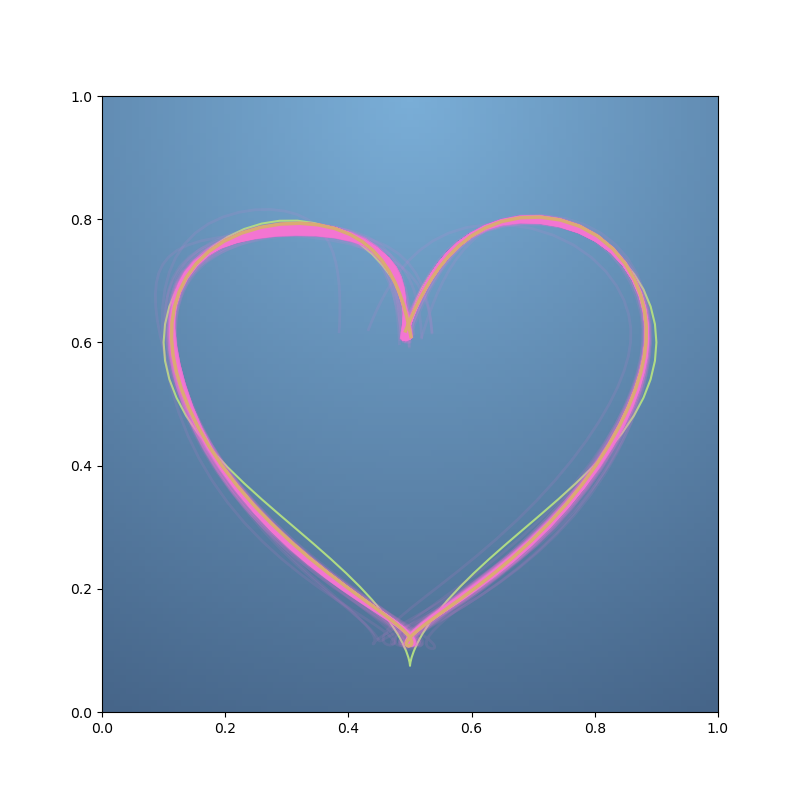

In [9]:
plot_training(x, y, iterations=50000, aggression=5, noise=0.8)